In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [4]:
from scipy.io import loadmat
from scipy.special import softmax

import pandas as pd
import numpy as np

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F

import time
import os
import copy


import cv2
from PIL import Image
import albumentations 
from albumentations import torch as AT
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
 
import warnings
warnings.filterwarnings('once')


plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

cuda:0
Tesla T4


In [0]:
#Reading all the .mat files
train_annos = loadmat('/content/drive/My Drive/devkit/cars_train_annos.mat')
test_annos = loadmat('/content/drive/My Drive/devkit/cars_test_annos.mat')
labels = loadmat('/content/drive/My Drive/devkit/cars_meta.mat')
test_annos_with_labels = loadmat('/content/drive/My Drive/cars_test_annos_withlabels.mat')

#Write all the labels as Cars models in separate list
labels = labels['class_names'][0]

In [0]:
#Data cleaning
data_train = [[row.flat[0] for row in line] for line in train_annos["annotations"][0]]
columns_train = ["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "class", "fname"]
df_train = pd.DataFrame(data_train, columns=columns_train)
df_train['class'] = df_train['class']-1 #we need to make all the lables starting with 0, as putorch requires so.

data_test = [[row.flat[0] for row in line] for line in test_annos_with_labels["annotations"][0]]
columns_test = ["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2","class","fname"]
df_test = pd.DataFrame(data_test, columns=columns_test)
df_test['class'] = df_test['class']-1

In [0]:
class CarsDataset(Dataset):
    def __init__(self, datafolder, df=None, transform = transforms.Compose([transforms.ToTensor()])):
        
        self.datafolder = datafolder
        self.labels = df['class'].values
        self.image_fname = df['fname'].values
        self.bboxes = df[["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2"]].values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def crop_bbox(self,bbox,img_fname):
        """ Method cropps image by provided in .mat file bounding boxes
        """
        image = cv2.imread(img_fname)
        l1, l0,_ = image.shape
        
        b0 = bbox[2] - bbox[0]
        b1 = bbox[3] - bbox[1]
        x0n,x1n = max(int(bbox[0] - b0*0.05),0), min(int(bbox[2] + b0*0.05),l0-1)
        y0n,y1n = max(int(bbox[1] - b1*0.05),0), min(int(bbox[3] + b1*0.05),l1-1)
        
        image = image[y0n:y1n,x0n:x1n]
        return  image
    
    def __getitem__(self, idx):
        
        img_name = os.path.join(self.datafolder, self.image_fname[idx])
        label = self.labels[idx]
        image = self.crop_bbox(self.bboxes[idx], img_name)
        
        
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         if self.transform:
#             augmented = self.transform(image=image)
#             image = augmented['image']

#             return image, label

        image = Image. fromarray(image).convert('RGB')
        image = self.transform(image)
        return image, label

In [0]:
#Set transforms for train and val sets
data_transforms = albumentations.Compose([
    albumentations.Resize(400, 400),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightnessContrast(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.JpegCompression(80),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])
data_transforms_test = albumentations.Compose([
    albumentations.Resize(400, 400),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

#Create Datsets using previously created class
train_set = CarsDataset(datafolder='/content/drive/My Drive/cars_train', df=df_train, transform=data_transforms)
test_set = CarsDataset(datafolder='/content/drive/My Drive/cars_test',df=df_test, transform=data_transforms_test)

train_sampler = torch.utils.data.SubsetRandomSampler(list(range(len(os.listdir('/content/drive/My Drive/cars_train')))))

#Using small batch size due to big images size, as I'm training on free GPU with Google Colab
batch_size = 8
num_workers = 2

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)

dataset_sizes = {'train': len(train_set), 'val':len(test_set)}

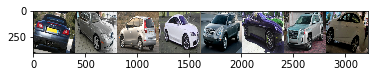

In [12]:
def imshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [0]:
#Define metrics for classification
def performance_metrics(true,pred):
    
    precision = metrics.precision_score(true,pred,average='macro', labels=np.unique(pred))
    recall = metrics.recall_score(true,pred,average='macro', labels=np.unique(pred))
    f1_score = metrics.f1_score(true,pred,average='macro', labels=np.unique(pred))
    
    return [precision, recall, f1_score]
    

    

def train_model(model, criterion, optimizer, scheduler,model_fname, num_epochs=25 ):
    
    time_start = time.time()
    
    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_acc = 0.0
    
    loss_list_val = []
    loss_list_train = []
    acc_list_val = []
    acc_list_train = []
        
    
    for epoch in range(num_epochs):
        
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('='*85)
        
        for phase in ['train', 'val']:
            
            if phase=='train':
                scheduler.step(epoch_acc)
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = test_loader
                
            running_loss = 0.0
            running_corrects = 0
            
            metrics_list = []
            precision, recall, f1_score = 0.0, 0.0, 0.0
            
            #Iterate over the dataloader
            
            for inputs, classes in loader:
                inputs = inputs.to(device)
                classes = classes.to(device)
                                
                optimizer.zero_grad()
                
                #forward propagation
                with torch.set_grad_enabled(phase=='train'):
                    
                    outputs  = model(inputs)
                    _, preds = torch.max(outputs, 1)   
                    loss = criterion(outputs, classes)
                    
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                
                #Calculate statistics
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+=torch.sum(preds==classes.data)
               
                metrics_list = performance_metrics(classes.cpu(), preds.cpu())
                precision += metrics_list[0]
                recall += metrics_list[1]
                f1_score += metrics_list[2]
                
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'val':
                loss_list_val.append(epoch_loss)
                acc_list_val.append(epoch_acc)
            else:
                loss_list_train.append(epoch_loss)
                acc_list_train.append(epoch_acc)
           
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            print('{} Loss: {:.4f} Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1_Score: {:.4f}'
                  .format(phase, epoch_loss, epoch_acc, precision/len(loader), recall/len(loader), f1_score/len(loader)))
            
        print()
        
    time_elapsed = time.time() - time_start
    
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    path = F"/content/drive/My Drive/{model_fname}" 
    torch.save(model.state_dict(), path)
    
    return  loss_list_train, loss_list_val, acc_list_train, acc_list_val
 

In [14]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.resnext50_32x4d(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 196)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max', patience=2, threshold = 0.9)

loss_list_train, loss_list_val, acc_list_train, acc_list_val = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,'test.pth',
                           num_epochs=15)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 100441675/100441675 [00:01<00:00, 62840952.72it/s]


Epoch 0/14


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


train Loss: 4.6933 Accuracy: 0.0646 Precision: 0.0695 Recall: 0.0789 F1_Score: 0.0717
val Loss: 3.3191 Accuracy: 0.2905 Precision: 0.2959 Recall: 0.3054 F1_Score: 0.2986

Epoch 1/14
train Loss: 2.9126 Accuracy: 0.3658 Precision: 0.3698 Recall: 0.3704 F1_Score: 0.3692
val Loss: 1.6254 Accuracy: 0.6356 Precision: 0.6378 Recall: 0.6420 F1_Score: 0.6385

Epoch 2/14
train Loss: 1.6382 Accuracy: 0.6708 Precision: 0.6706 Recall: 0.6692 F1_Score: 0.6693
val Loss: 0.8311 Accuracy: 0.8023 Precision: 0.8033 Recall: 0.8056 F1_Score: 0.8036

Epoch 3/14
train Loss: 0.9384 Accuracy: 0.8308 Precision: 0.8307 Recall: 0.8278 F1_Score: 0.8285
val Loss: 0.5312 Accuracy: 0.8697 Precision: 0.8705 Recall: 0.8716 F1_Score: 0.8705

Epoch 4/14
train Loss: 0.5787 Accuracy: 0.9073 Precision: 0.9070 Recall: 0.9058 F1_Score: 0.9059
val Loss: 0.3865 Accuracy: 0.9020 Precision: 0.9025 Recall: 0.9031 F1_Score: 0.9025

Epoch 5/14
train Loss: 0.3520 Accuracy: 0.9538 Precision: 0.9536 Recall: 0.9532 F1_Score: 0.9532
val 

In [22]:
data_transforms_test = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

df = pd.read_csv('/content/drive/My Drive/df_test.csv')
df['class'] = df['class']-1
test_set = CarsDataset(datafolder='/content/drive/My Drive/test_test',df=df, transform=data_transforms_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)


def test_set_accuracy(model, testloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print('Accuracy of the model on the test images: %d %%' % (
        100 * correct / total))
    


def load_model(model_file):
    model_ft = models.resnext50_32x4d(pretrained=True) 
    model_ft.fc = torch.nn.Linear(model_ft.fc.in_features, 196)
    checkpoint = torch.load(model_file)
    model_ft.load_state_dict(checkpoint)
    return model_ft
    
    
model=load_model(f'/content/drive/My Drive/resnext50_93.4.pth')
model.eval()

test_set_accuracy(model,test_loader )

Accuracy of the model on the test images: 100 %


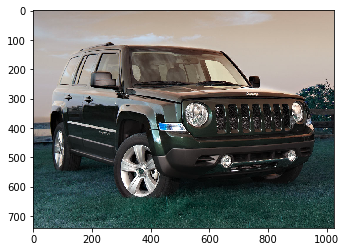

Class: Jeep Patriot SUV 2012 , confidence: 95.85%
Class: Jeep Liberty SUV 2012 , confidence: 0.98%
Class: Jeep Wrangler SUV 2012 , confidence: 0.82%
Class: Jeep Compass SUV 2012 , confidence: 0.65%
Class: Land Rover Range Rover SUV 2012 , confidence: 0.56%


tensor([144])

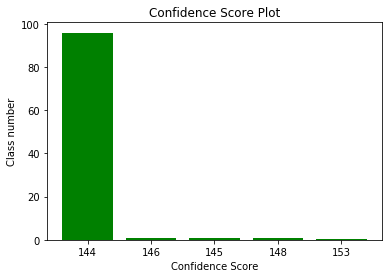

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def predict_one_image(model,img_fname,device, transforms = None):

    img = cv2.imread(img_fname)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    image = Image. open(img_fname).convert('RGB')
    image_tr= data_transforms_test(image)
    data = image_tr.expand(1,-1,-1,-1)

    probs = nn.Softmax(dim = 1)
    output = model(data)
    output = probs(output)
    _, predicted = torch.max(output.data, 1)
    
    img_plot(img)
    prediction_bar(output)
    
    return predicted

def prediction_bar(output):
    
    output = output.detach().numpy()
    pred_labels = output.argsort()[0]
    pred_labels = np.flip(pred_labels[-1*len(pred_labels):])
    
    prediction, label = [], []
    
    for i in pred_labels[:5]:
        prediction.append(float(output[:,i]*100))
        label.append(str(i))
        
    for i in pred_labels[:5]:
        print('Class: {} , confidence: {:.2f}%'.format(labels[int(i)][0],float(output[:,i])*100))
        
    plt.bar(label,prediction, color='green')
    plt.title("Confidence Score Plot")
    plt.xlabel("Confidence Score")
    plt.ylabel("Class number")
    
    return None
 
def img_plot(image):
    
    plt.imshow(image)
    plt.show()

image_name = '/content/drive/My Drive/cars_test/00003.jpg'
predict_one_image(model,image_name, device, transforms = data_transforms_test)